 # World University Rankings

**Nomes:** Daniel, Davi, Eduardo, João

**Matriculas:**

 ## Introdução


(Introdução com Motivação e Pergunta de Pesquisa)




#### Perguntas

1 - H0 - A proporção de estudantes internacionais impacta no ranking da universidade        (Intervalo de confiança)

2 - H0 - Universidades mais disputadas (com menos alunos) possuem classificações melhores    (Intervalo de confiança)

    |-> Se influencia, temos como prever a pontuação final da universidade dado o número de alunos?    (Regressão)
    
3 - Detectar se a proporção entre homens e mulheres teve uma tendencia geral ao longo do tempo

4 - Podemos prever a posição/pontuação média das universidades de um país dado o seu investimento em educação? (Regressão)

## Metodologia

(Descreva sua base)

## Quais métodos e modelos foram utilizados.

(Justifique os mesmos.)

## Resultados
(análise exploratória)
(Testes de hipótese podem vir aqui.)


In [91]:
import pandas as pd
import matplotlib as plt
import numpy as np

### TimesData

Primeiramente, importamos e analisamos os dados como estão sendo mostrados.

In [92]:
timesData = pd.read_csv("timesData.csv")

In [93]:
timesData.describe()

,teaching,research,citations,student_staff_ratio,year
count,2603.000000,2603.000000,2603.000000,2544.000000,2603.000000
mean,37.801498,35.910257,60.921629,18.445283,2014.075682
std,17.604218,21.254805,23.073219,11.458698,1.685733
min,9.900000,2.900000,1.200000,0.600000,2011.000000
25%,24.700000,19.600000,45.500000,11.975000,2013.000000
50%,33.900000,30.500000,62.500000,16.100000,2014.000000
75%,46.400000,47.250000,79.050000,21.500000,2016.000000
max,99.700000,99.400000,100.000000,162.600000,2016.000000


In [94]:
timesData.head(3)


,world_rank,university_name,country,teaching,international,research,citations,income,total_score,num_students,student_staff_ratio,international_students,female_male_ratio,year
0,1,Harvard University,United States of America,99.7,72.4,98.7,98.8,34.5,96.1,"20,152",8.9,25%,NaN,2011
1,2,California Institute of Technology,United States of America,97.7,54.6,98.0,99.9,83.7,96.0,"2,243",6.9,27%,33 : 67,2011
2,3,Massachusetts Institute of Technology,United States of America,97.8,82.3,91.4,99.9,87.5,95.6,"11,074",9.0,33%,37 : 63,2011


### Tipos de dados

Separamos os tipos de dados para facilitar a exploração dos dados futuramente.

$$ Numeral $$

Discreto | Continuo
:--------- | -------:
world_rank | teaching
num_students |international
year |research
  |citations
  |income
  |total_score
  |student_staff_ratio
  |international_students
  |female_male_ratio



$$ Categorico $$

Categorico | Ordinal
:--------- | -------:
university_name	 | 
country	 | 



Verificamos a quantidade de valores nulos na tabela.

In [95]:
timesData.isna().sum()

world_rank                  0
university_name             0
country                     0
teaching                    0
international               0
research                    0
citations                   0
income                      0
total_score                 0
num_students               59
student_staff_ratio        59
international_students     67
female_male_ratio         233
year                        0
dtype: int64

<AxesSubplot:>

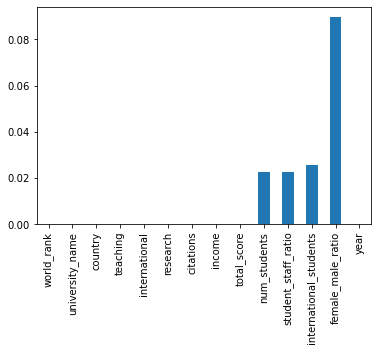

In [96]:
timesDataNaN = timesData.isna().sum()
timesDataNaN = timesDataNaN/len(timesData)
timesDataNaN.plot(kind='bar')

### Tratamento de Dados da timesData

In [97]:
def defineFemaleRatio(df):
    """
    Altera a coluna female_male_ratio para que mostre apenas a porcentagem de mulheres na universidade.
    Além disso, remove valores iguais a "-" e os salva como NaN.
    Dessa forma, fica mais fácil de analisar essa coluna. Retorna um novo dataframe sem alterar o df passado
    """
    dfNovo = df.copy()
    dfNovo.index = range(len(df))
    for i in range(len(dfNovo)):
        if (not pd.isna(dfNovo.iloc[i,12])):
            if dfNovo.at[i,'female_male_ratio'] == '-':
                dfNovo.at[i,'female_male_ratio'] = np.nan
            else:
                dfNovo.at[i,'female_male_ratio'] = int(dfNovo.at[i,'female_male_ratio'].strip()[0:2])
    return dfNovo
            
def retiraPorcentagem(df):
    """
    Retira o símbolo de % da coluna 'international_students' e retorna um novo dataset sem modificar o original.
    """
    dfNovo = df.copy()
    dfNovo.index = range(len(dfNovo))
    for i in range(len(dfNovo)):
        if (not pd.isna(dfNovo.iloc[i,11])):
            valorNovo = dfNovo.at[i,'international_students']
            if '%' in valorNovo:
                valorNovo = valorNovo[:-1]
            if valorNovo.strip() not in ['']:
                dfNovo.at[i,'international_students'] = int(valorNovo)
    return dfNovo

def retiraVirgulaNumAlunos(df):
    """
    df: Um dataframe
    Retira a vírgula que separa os números da coluna num_students e os converte para inteiro para que
    possam ser usados como dados em plots. Não altera o dataframe passado. Retorna um novo dataframe
    """
    dfNovo = df.copy()
    dfNovo.index = range(len(dfNovo))
    for i in range(len(dfNovo)):
        if(not pd.isna(df.at[i,'num_students'])):
            dfNovo.at[i,'num_students'] = int(dfNovo.at[i,'num_students'].replace(',','',1))
    return dfNovo

def isFloat(value):
    """
    Retorna True se é possível converter o valor para float e False caso não seja possível
    """
    try:
        float(value)
        return True
    except ValueError:
        return False

def calculaTotalScore(linha):
    """
    linha: Um objeto Series contendo as seguintes colunas:
        teaching, international, research, citations, income e year
        
    Retorna o total_score (arredondado com 1 casa decimal) de uma universidade de acordo
    com as regras da Times. 
    Retorna -1 caso o valor em 'year' não esteja da faixa de (2011-2016) ou caso pelo menos uma das cinco
    categorias não tenha um valor float
    
    O peso de cada categoria varia por ano:
    
        2011:
            peso_teaching: 30%
            peso_income: 2.5%
            peso_citations: 32.5%
            peso_research: 30%
            peso_international: 5%
            
        2012,2013,2014,2015,2016:
            peso_teaching: 30%
            peso_income: 2.5%
            peso_citations: 30%
            peso_research: 30%
            peso_international: 7.5%
         
        total_score = {(teaching*peso_teaching) + (international * peso_international) +
                        (income * peso_income) + (citations * peso_citations) + 
                        (research * peso_research)}/(100)
    
    """
    peso_teaching = 30
    peso_income = 2.5
    peso_citations = 0
    peso_research = 30
    peso_international = 0
    teaching = 0
    income = 0
    citations = 0
    research = 0
    international = 0
    
    if(isFloat(linha['teaching'])):
        teaching = float(linha['teaching'])
    else:
        return -1.0
    
    if(isFloat(linha['income'])):
        income = float(linha['income'])
    else:
        return -1.0
    
    if(isFloat(linha['citations'])):
        citations = float(linha['citations'])
    else:
        return -1.0
    
    if(isFloat(linha['research'])):
        research = float(linha['research'])
    else:
        return -1.0
    
    if(isFloat(linha['international'])):
        international = float(linha['international'])
    else:
        return -1.0
    
    if int(linha['year']) == 2011:
        peso_citations = 32.5
        peso_international = 5
    elif int(linha['year']) in [2012,2013,2014,2015,2016]:
        peso_citations = 30
        peso_international = 7.5
    else:
        return -1.0
    
    total_score = ((teaching*peso_teaching) + (international * peso_international) +
                        (income * peso_income) + (citations * peso_citations) + 
                        (research * peso_research))/(100)
    return float(round(total_score,1))

def completaTotalScores(df):
    """
    df: Um dataframe
    Calcula a nota final de cada universidade se for possível. Caso não seja possível, -1 é colocado como nota.
    Retorna um novo dataframe sem alterar o df passado
    """
    dfNovo = df.copy()
    dfNovo.index = range(len(dfNovo))
    for i in range(len(dfNovo)):
        novaNota = 0
        novaNota = calculaTotalScore(dfNovo.iloc[i])
        dfNovo.at[i,'total_score'] = novaNota
    return dfNovo

def trataDadosTimes(df):
    """
    df: Um dataframe, de preferência, o dataset da times original.
    Trata os dados do dataset de acordo com todas as regras existentes que devem ser aplicadas até agora.
    Retorna um novo dataframe sem alterar o original.
    """
    dfNovo = completaTotalScores(timesData)
    dfNovo = retiraPorcentagem(dfNovo)
    dfNovo = retiraVirgulaNumAlunos(dfNovo)
    dfNovo = defineFemaleRatio(dfNovo)
    return dfNovo

In [98]:
#Tratando os dados da times
timesCompleto = trataDadosTimes(timesData)

In [99]:
timesCompleto.describe()

,teaching,research,citations,student_staff_ratio,year
count,2603.000000,2603.000000,2603.000000,2544.000000,2603.000000
mean,37.801498,35.910257,60.921629,18.445283,2014.075682
std,17.604218,21.254805,23.073219,11.458698,1.685733
min,9.900000,2.900000,1.200000,0.600000,2011.000000
25%,24.700000,19.600000,45.500000,11.975000,2013.000000
50%,33.900000,30.500000,62.500000,16.100000,2014.000000
75%,46.400000,47.250000,79.050000,21.500000,2016.000000
max,99.700000,99.400000,100.000000,162.600000,2016.000000


In [100]:
timesCompleto.head(3)

,world_rank,university_name,country,teaching,international,research,citations,income,total_score,num_students,student_staff_ratio,international_students,female_male_ratio,year
0,1,Harvard University,United States of America,99.7,72.4,98.7,98.8,34.5,96.1,20152,8.9,25,NaN,2011
1,2,California Institute of Technology,United States of America,97.7,54.6,98.0,99.9,83.7,96,2243,6.9,27,33,2011
2,3,Massachusetts Institute of Technology,United States of America,97.8,82.3,91.4,99.9,87.5,95.5,11074,9.0,33,37,2011


Com o tratamento da timesData completo, podemos partir para analisar as proximas tabelas do nosso dataset.

### PibPaises

Foi usado o dataset de PIB de todos paises, pois tinhamos dados suplementares que continham a porcentagem do PIB de cada país gasto em educação.

In [101]:
pibPaises = pd.read_csv("pibPaises.csv")

In [102]:
pibPaises.head(3)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.534637e+09,2.701676e+09,2.765363e+09,2.919553e+09,2.965922e+09,3.056425e+09,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,5.377778e+08,5.488889e+08,5.466667e+08,7.511112e+08,8.000000e+08,1.006667e+09,...,2.000160e+10,2.056107e+10,2.048489e+10,1.990711e+10,1.801775e+10,1.886995e+10,1.835388e+10,1.929110e+10,NaN,NaN
2,Angola,AGO,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.280529e+11,1.367099e+11,1.457122e+11,1.161936e+11,1.011239e+11,1.221238e+11,1.013532e+11,8.881570e+10,NaN,NaN


In [103]:
pibPaises1 = pibPaises.iloc[:,55:61]
NomesPaises = pibPaises.iloc[:,0]
pibPaises1 = pibPaises1/1000000000
pibPaisesCompleto = pd.concat([NomesPaises, pibPaises1], axis=1)

In [104]:
pibPaisesCompleto.head(3)

,Country Name,2011,2012,2013,2014,2015,2016
0,Aruba,2.549721,2.534637,2.701676,2.765363,2.919553,2.965922
1,Afghanistan,17.804293,20.001599,20.561070,20.484885,19.907111,18.017749
2,Angola,111.789686,128.052854,136.709863,145.712200,116.193649,101.123851


### exData

Tabela que contêm porcentagem de gastos do pib de cada país com educação.

In [105]:
exData = pd.read_csv("education_expenditure_supplementary_data.csv")

In [106]:
exTotal = exData.iloc[223:,np.r_ [0,11:17]]
exTotal.reset_index(drop=True, inplace=True)
exTotal.head(3)

,country,2011,2012,2013,2014,2015,2016
0,Australia,5.8,5.6,5.6,5.7,6.0,5.8
1,Austria,5.7,4.9,5.0,4.9,4.9,4.9
2,Belgium,6.6,5.9,5.8,5.8,5.8,5.7


União das duas tabelas para saber o valor exato gasto em trilhões com educação.

In [107]:
investimentoPIB = pibPaisesCompleto.merge(exTotal,
        how = "inner",
        left_on = "Country Name", right_on = "country")
investimentoPIB = investimentoPIB.drop_duplicates(subset=['Country Name'], keep='last')
investimentoPIB.reset_index(drop=True, inplace=True)
investimentoPIB.head(3)

,Country Name,2011_x,2012_x,2013_x,2014_x,2015_x,2016_x,country,2011_y,2012_y,2013_y,2014_y,2015_y,2016_y
0,Australia,1396.649906,1546.151784,1576.184467,1467.483705,1351.693985,1208.846994,Australia,1.6,1.6,1.7,1.8,2.1,2.0
1,Austria,431.120310,409.425234,430.068713,441.996132,381.817566,395.568644,Austria,1.5,1.7,1.7,1.7,1.7,1.7
2,Belgium,522.645519,496.181260,521.642714,534.678076,462.149679,475.739589,Belgium,1.4,1.4,1.4,1.4,1.4,1.4


### Tratamento de Dados
Foi feito o tratamento de dados da junção das duas tabelas

In [108]:
investimentoPIB.rename(columns={"Country Name": "country"})
investimentoPIB.country.unique()

array(['Australia', 'Austria', 'Belgium', 'Brazil', 'Canada',
       'Switzerland', 'Chile', 'Czech Republic', 'Germany', 'Denmark',
       'Spain', 'Estonia', 'Finland', 'France', 'United Kingdom',
       'Greece', 'Hungary', 'Ireland', 'Iceland', 'Israel', 'Italy',
       'Japan', 'Luxembourg', 'Mexico', 'Netherlands', 'Norway',
       'New Zealand', 'Poland', 'Portugal', 'Russian Federation',
       'Slovak Republic', 'Slovenia', 'Sweden', 'Turkey', 'United States'],
      dtype=object)

In [109]:
investimentoPIB['Result2011'] = investimentoPIB['2011_x']*investimentoPIB['2011_y']/100
investimentoPIB['Result2012'] = investimentoPIB['2012_x']*investimentoPIB['2012_y']/100
investimentoPIB['Result2013'] = investimentoPIB['2013_x']*investimentoPIB['2013_y']/100
investimentoPIB['Result2014'] = investimentoPIB['2014_x']*investimentoPIB['2014_y']/100
investimentoPIB['Result2015'] = investimentoPIB['2015_x']*investimentoPIB['2015_y']/100
investimentoPIB['Result2016'] = investimentoPIB['2016_x']*investimentoPIB['2016_y']/100

Tratamento da junção das duas tabelas completo

In [114]:
investimentoEducacao = investimentoPIB.iloc[:,np.r_ [0,14:20]]
investimentoEducacao

,Country Name,Result2011,Result2012,Result2013,Result2014,Result2015,Result2016
0,Australia,22.346399,24.738429,26.795136,26.414707,28.385574,24.176940
1,Austria,6.466805,6.960229,7.311168,7.513934,6.490899,6.724667
2,Belgium,7.317037,6.946538,7.302998,7.485493,6.470096,6.660354
3,Brazil,NaN,22.186698,22.255262,19.647949,NaN,NaN
4,Canada,NaN,0.000000,0.000000,46.891863,37.347109,35.149594
5,Switzerland,NaN,8.016523,8.262050,9.219373,8.837820,8.727020
6,Chile,6.054048,6.678058,6.681224,6.252999,4.878382,6.261003
7,Czech Republic,3.213878,2.924008,2.751913,2.512306,1.880331,1.766449
8,Germany,48.677312,42.328139,44.792921,50.490962,40.274828,41.609976
9,Denmark,6.536060,0.000000,5.840935,6.000892,0.000000,0.000000


In [111]:
investimentoEducacao.describe()

,Result2011,Result2012,Result2013,Result2014,Result2015,Result2016
count,28.000000,35.000000,35.000000,35.000000,34.000000,34.000000
mean,30.091092,26.031835,26.042688,27.881648,26.170497,25.786177
std,79.087975,76.732106,73.596319,76.633479,80.633149,79.691845
min,0.181903,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.528354,2.120850,2.807218,3.028769,1.958361,1.892123
50%,7.092477,6.946538,7.302998,7.513934,6.480497,6.692511
75%,22.489776,17.799477,19.512500,19.689108,16.188748,14.951013
max,419.649690,453.516206,436.406079,455.706256,473.842315,467.874013


In [112]:
investimentoEducacao.isna().sum()

Country Name    0
Result2011      7
Result2012      0
Result2013      0
Result2014      0
Result2015      1
Result2016      1
dtype: int64

<AxesSubplot:>

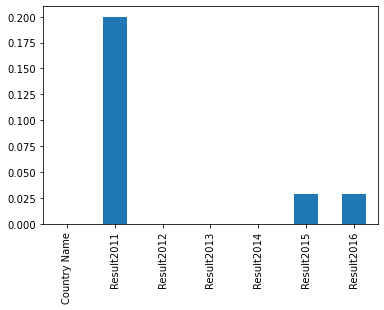

In [113]:
investimentoEducacaoNaN = investimentoEducacao.isna().sum()
investimentoEducacaoNaN = investimentoEducacaoNaN/len(investimentoEducacao)
investimentoEducacaoNaN.plot(kind='bar')

### Tipos de dados

Separamos os tipos de dados para facilitar a exploração dos dados futuramente.

$$ Numeral $$

Discreto | Continuo
:--------- | -------:
 | Result2011	a Result2016	

$$ Categorico $$

Categorico | Ordinal
:--------- | -------:
Country Name | 

...

Descobrir o total_score de cada pais usando a media total das universidades e usando cada ano especifico

Fazer um grafico scatter total_score 







In [206]:
timesCompleto[timesCompleto['world_rank']=='1'][['university_name', 'country', 'total_score','year']]

,university_name,country,total_score,year
0,Harvard University,United States of America,96.1,2011
200,California Institute of Technology,United States of America,94.8,2012
602,California Institute of Technology,United States of America,95.5,2013
1002,California Institute of Technology,United States of America,94.9,2014
1402,California Institute of Technology,United States of America,94.3,2015
1803,California Institute of Technology,United States of America,95.1,2016


In [201]:
timesTratado2011=timesCompleto[timesCompleto['year']==2011][['university_name', 'country', 'total_score','year']]
#Arrumar a questao do total score -1
timesTratado2011=timesTratado2011[timesTratado2011['total_score']!=-1]

timesTratado2012=timesCompleto[timesCompleto['year']==2012][['university_name', 'country', 'total_score','year']]
#Arrumar a questao do total score -1
timesTratado2012=timesTratado2012[timesTratado2012['total_score']!=-1]

timesTratado2013=timesCompleto[timesCompleto['year']==2013][['university_name', 'country', 'total_score','year']]
#Arrumar a questao do total score -1
timesTratado2013=timesTratado2013[timesTratado2013['total_score']!=-1]

timesTratado2014=timesCompleto[timesCompleto['year']==2014][['university_name', 'country', 'total_score','year']]
#Arrumar a questao do total score -1
timesTratado2014=timesTratado2014[timesTratado2014['total_score']!=-1]

timesTratado2015=timesCompleto[timesCompleto['year']==2015][['university_name', 'country', 'total_score','year']]
#Arrumar a questao do total score -1
timesTratado2015=timesTratado2015[timesTratado2015['total_score']!=-1]

timesTratado2016=timesCompleto[timesCompleto['year']==2016][['university_name', 'country', 'total_score','year']]
#Arrumar a questao do total score -1
timesTratado2016=timesTratado2016[timesTratado2016['total_score']!=-1]




In [202]:
timesTratado2011


,university_name,country,total_score,year
0,Harvard University,United States of America,96.1,2011
1,California Institute of Technology,United States of America,96,2011
2,Massachusetts Institute of Technology,United States of America,95.5,2011
3,Stanford University,United States of America,94.2,2011
5,University of Cambridge,United Kingdom,91.2,2011
...,...,...,...,...
193,KTH Royal Institute of Technology,Sweden,46.8,2011
194,University of Vienna,Austria,46.6,2011
195,Kent State University,United States of America,46.5,2011
197,Zhejiang University,China,46.4,2011


In [204]:
SumTimes2011=timesTratado2011.groupby('country')['total_score'].sum()
CountTimes2011=timesTratado2011.groupby('country')['total_score'].count()
MediaNotaPais2011=SumTimes2011/CountTimes2011
MediaNotaPais2011=MediaNotaPais2011.sort_values(ascending=False)
MediaNotaPais2011=MediaNotaPais2011.to_frame()
MediaNotaPais2011=MediaNotaPais2011.rename(columns={"total_score": 2011})


SumTimes2012=timesTratado2012.groupby('country')['total_score'].sum()
CountTimes2012=timesTratado2012.groupby('country')['total_score'].count()
MediaNotaPais2012=SumTimes2012/CountTimes2012
MediaNotaPais2012=MediaNotaPais2012.to_frame()
MediaNotaPais2012=MediaNotaPais2012.rename(columns={"total_score": 2012})


SumTimes2013=timesTratado2013.groupby('country')['total_score'].sum()
CountTimes2013=timesTratado2013.groupby('country')['total_score'].count()
MediaNotaPais2013=SumTimes2013/CountTimes2013
MediaNotaPais2013=MediaNotaPais2013.to_frame()
MediaNotaPais2013=MediaNotaPais2013.rename(columns={"total_score": 2013})


SumTimes2014=timesTratado2014.groupby('country')['total_score'].sum()
CountTimes2014=timesTratado2014.groupby('country')['total_score'].count()
MediaNotaPais2014=SumTimes2014/CountTimes2014
MediaNotaPais2014=MediaNotaPais2014.to_frame()
MediaNotaPais2014=MediaNotaPais2014.rename(columns={"total_score": 2014})


SumTimes2015=timesTratado2015.groupby('country')['total_score'].sum()
CountTimes2015=timesTratado2015.groupby('country')['total_score'].count()
MediaNotaPais2015=SumTimes2015/CountTimes2015
MediaNotaPais2015=MediaNotaPais2015.to_frame()
MediaNotaPais2015=MediaNotaPais2015.rename(columns={"total_score": 2015})


SumTimes2016=timesTratado2016.groupby('country')['total_score'].sum()
CountTimes2016=timesTratado2016.groupby('country')['total_score'].count()
MediaNotaPais2016=SumTimes2016/CountTimes2016
MediaNotaPais2016=MediaNotaPais2016.to_frame()
MediaNotaPais2016=MediaNotaPais2016.rename(columns={"total_score": 2016})


MediaNotaPais = MediaNotaPais2012.merge(MediaNotaPais2013,
        how = "inner",
        left_on = "country", right_on = "country")

MediaNotaPais = MediaNotaPais.merge(MediaNotaPais2013,
        how = "inner",
        left_on = "country", right_on = "country")

MediaNotaPais.count()


2012    38
2013    38
dtype: int64

In [200]:
MediaNotaPais2011.count()



2011    26
dtype: int64

2012    40
dtype: int64

In [150]:
timesTratado2011[timesTratado2011['country']=='Turkey']

,university_name,country,total_score,year
111,Bilkent University,Turkey,55.4,2011
182,Middle East Technical University,Turkey,47.7,2011


### Exploração dos dados

Com os dados tratados podemos começar a analisar

## Previsão

(uma ou duas subseções dependendo dos modelos utilizados)

## Conclusões